# **I320D Final Project - Deep Learning for Multi-Class Brain Tumor Identification**

**Group Name:** First Classifiers

**Group Member Names:** Harini Chandrasekhar, Serena Manwani, Ella Johnson

**Course:** I320D - Applied Machine Learning With Python


##**Importing Libraries and Data Read-In**

In [ ]:
#Import below libraries
import os
import pandas as pd
import pathlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
import kagglehub
import numpy as np
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
from PIL import Image, ImageOps
from tensorflow.keras import backend as K
import gc
import pickle
!pip install gradio
import gradio as gr

# Use the following two lines if you face issues in printing dataframes using the head() method
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Download dataset
#Kaggle API method
path = kagglehub.dataset_download("denizkavi1/brain-tumor")
data_dir = pathlib.Path(path).with_suffix('')
print("Path to dataset files:", data_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


100%|██████████| 700M/700M [00:06<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2


##**Data Preparation + Preprocessing**

### **Converting to Dataframe + Assigning Class Labels**

In [ ]:
#Check image count
image_count = len(list(data_dir.glob('*/*.png')))
print(f"Number of images: {image_count}")

#https://tensorflow.org/tutorials/images/classification - Reference

#Load the dataset using TensorFlow
brain_tumor_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred")

class_names = ['Meningioma Tumor', 'Glioma Tumor', 'Pituitary Tumor']
#Create a DataFrame with file paths and labels
image_paths = list(data_dir.glob('*/*.png'))
brain_tumor_df = pd.DataFrame(
    [{"Filepath": str(img), "Labels": img.parent.name} for img in image_paths]
)
# Count the number of images per class
class_counts = brain_tumor_df['Labels'].value_counts()

# Display the result
print(class_counts)
#Display the first few rows of the DataFrame
brain_tumor_df.head()

Number of images: 3064
Found 3064 files belonging to 3 classes.
Labels
2    1426
3     930
1     708
Name: count, dtype: int64


,Filepath,Labels
0,/root/.cache/kagglehub/datasets/denizkavi1/bra...,3
1,/root/.cache/kagglehub/datasets/denizkavi1/bra...,3
2,/root/.cache/kagglehub/datasets/denizkavi1/bra...,3
3,/root/.cache/kagglehub/datasets/denizkavi1/bra...,3
4,/root/.cache/kagglehub/datasets/denizkavi1/bra...,3


### **Feature & Label Extraction - Data Split (Test: 10% - Validation: 10% - Training: 80%)**

In [ ]:
#Load file paths and labels as features and labels
features = brain_tumor_df["Filepath"].to_numpy()
labels = brain_tumor_df["Labels"].to_numpy()

# Split the dataset: 80% train, 10% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.20, random_state=320)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=320)

### **Image Resizing Based on Model Type**

In [ ]:
#Resize all images based on model reccommendations
def resize_image(filepath, model_type):
    #Read in the image
    image = tf.io.read_file(filepath)
    #Make it RGB
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    #Resize for each model type
    if model_type == 'VGG16':
        image = tf.image.resize(image, (32, 32))
    elif model_type == 'ResNet50':
        image = tf.image.resize(image, (224, 224))
    elif model_type == 'InceptionV3':
        image = tf.image.resize(image, (299, 299))
    #Normalize the image to [0, 1]
    image = image / 255.0
    return image

In [ ]:
# Resize images for VGG16
x_train_vgg16 = np.array([resize_image(f, 'VGG16') for f in x_train])
x_valid_vgg16 = np.array([resize_image(f, 'VGG16') for f in x_valid])
x_test_vgg16 = np.array([resize_image(f, 'VGG16') for f in x_test])

In [ ]:
# Resize images for ResNet50
x_train_resnet50 = np.array([resize_image(f, 'ResNet50') for f in x_train])
x_valid_resnet50 = np.array([resize_image(f, 'ResNet50') for f in x_valid])
x_test_resnet50 = np.array([resize_image(f, 'ResNet50') for f in x_test])

In [ ]:
# Resize images for InceptionV3
x_train_inceptionv3 = np.array([resize_image(f, 'InceptionV3') for f in x_train])
x_valid_inceptionv3 = np.array([resize_image(f, 'InceptionV3') for f in x_valid])
x_test_inceptionv3 = np.array([resize_image(f, 'InceptionV3') for f in x_test])

In [ ]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the encoder on the training labels
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_valid_encoded = encoder.transform(y_valid.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.reshape(-1, 1)).toarray()

# Print the shapes of the encoded labels
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_valid_encoded shape: {y_valid_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

y_train_encoded shape: (2451, 3)
y_valid_encoded shape: (306, 3)
y_test_encoded shape: (307, 3)


### **Preprocessing Visualizations**

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Input Size Comparison for Different Models')

Text(0.5, 0, 'Model Tpe')

Text(0, 0.5, 'Input Size (Pixels)')

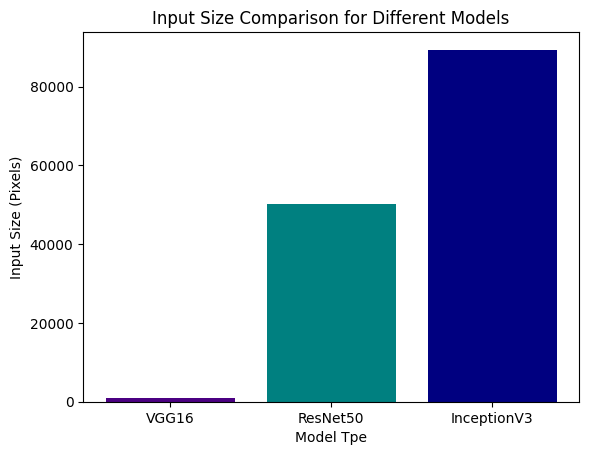

In [ ]:
#Models and their respective input sizes
models = ['VGG16', 'ResNet50', 'InceptionV3']
sizes = [32 * 32, 224 * 224, 299 * 299]

#Create the bar chart
plt.bar(models, sizes, color=['indigo', 'teal', 'navy'])

#Add title and labels
plt.title("Input Size Comparison for Different Models")
plt.xlabel("Model Tpe")
plt.ylabel("Input Size (Pixels)")

#Display the plot
plt.show()

Text(0.5, 1.0, 'VGG16 - Sample 1')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'ResNet50 - Sample 1')

(-0.5, 223.5, 223.5, -0.5)

Text(0.5, 1.0, 'InceptionV3 - Sample 1')

(-0.5, 298.5, 298.5, -0.5)

Text(0.5, 1.0, 'VGG16 - Sample 2')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'ResNet50 - Sample 2')

(-0.5, 223.5, 223.5, -0.5)

Text(0.5, 1.0, 'InceptionV3 - Sample 2')

(-0.5, 298.5, 298.5, -0.5)

Text(0.5, 1.0, 'VGG16 - Sample 3')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'ResNet50 - Sample 3')

(-0.5, 223.5, 223.5, -0.5)

Text(0.5, 1.0, 'InceptionV3 - Sample 3')

(-0.5, 298.5, 298.5, -0.5)

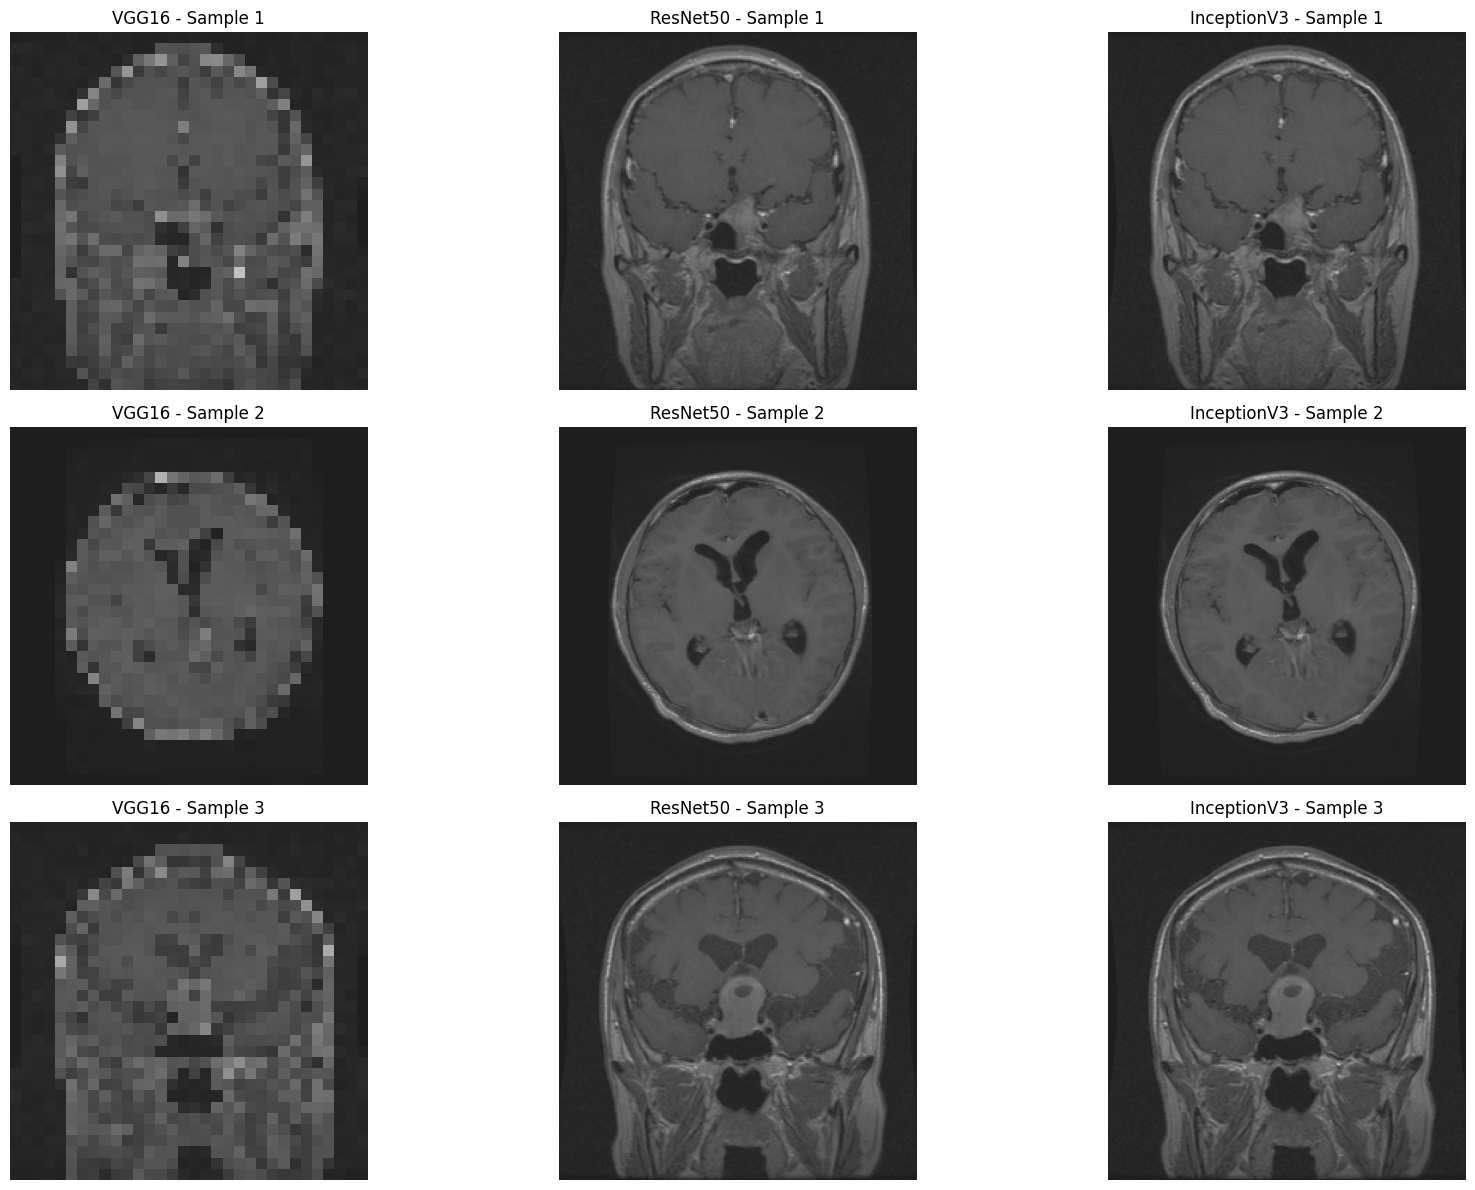

In [ ]:
#Select a few sample images from the training set
n_samples = 3
# Pick the first 3 images
sample_images = x_train_vgg16[:n_samples]

#Create subplots for VGG16, ResNet50, and InceptionV3
fig, axes = plt.subplots(n_samples, 3, figsize=(18, 4 * n_samples))

for i in range(n_samples):
    # Display the image resized for VGG16
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title(f"VGG16 - Sample {i+1}")
    axes[i, 0].axis('off')

    # Display the image resized for ResNet50
    axes[i, 1].imshow(x_train_resnet50[i])
    axes[i, 1].set_title(f"ResNet50 - Sample {i+1}")
    axes[i, 1].axis('off')

    # Display the image resized for InceptionV3
    axes[i, 2].imshow(x_train_inceptionv3[i])
    axes[i, 2].set_title(f"InceptionV3 - Sample {i+1}")
    axes[i, 2].axis('off')

# Show the plot
plt.tight_layout()

##**Applying Deep Learning Models**

###**VGG16 Model**

####**Training + Validating + Tuning the Model**

In [ ]:
#Set random seed for reproducibility
random.seed(320)
np.random.seed(320)
tf.random.set_seed(320)

#Load VGG16 pretrained model and freeze the layers
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_model.trainable = False

#Add layers on top of the base mode by flattening output and using Relu Activation and softmax out put
x = Flatten()(vgg16_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

#Build the final model
model_vgg16 = Model(inputs=vgg16_model.input, outputs=output)

#Set optimizer and loss function
optim = Adam(learning_rate=0.001)
loss_fn = CategoricalCrossentropy()

#Compile the model
model_vgg16.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

#Print the model summary
model_vgg16.summary()

#Start training the model
print("Training VGG16 model (32x32 input)")

#Set batch size
batch_size = 64
#Adjust for class weights for imbalance
class_weights = {0: 4.33, 1: 2.15, 2: 3.29}

# Train the model with the training data
model_vgg16.fit(x_train_vgg16, y_train_encoded, epochs=10, validation_data=(x_valid_vgg16, y_valid_encoded),
                batch_size=batch_size, class_weight=class_weights)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training VGG16 model (32x32 input)
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.4089 - loss: 3.1389 - val_accuracy: 0.6275 - val_loss: 0.8323
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.6762 - loss: 2.2412 - val_accuracy: 0.6732 - val_loss: 0.7458
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.7037 - loss: 2.0039 - val_accuracy: 0.6928 - val_loss: 0.6973
Epoch 4/10
14/39 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.7081 - loss: 1.9636

KeyboardInterrupt: 

####**Testing the Model**

In [ ]:
#Test the model and determine loss and accuracy
test_loss, test_acc = model_vgg16.evaluate(x_test_vgg16, y_test_encoded)
print("VGG16 Test Accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.7573 - loss: 0.5400
VGG16 Test Accuracy: 0.7719869613647461


####**Classification Report + Confusion Matrix**

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step
Classification Report for VGG16:
                  precision    recall  f1-score   support

Meningioma Tumor       0.57      0.70      0.63        67
    Glioma Tumor       0.88      0.68      0.77       149
 Pituitary Tumor       0.81      0.97      0.88        91

        accuracy                           0.77       307
       macro avg       0.75      0.78      0.76       307
    weighted avg       0.79      0.77      0.77       307



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted')

Text(45.72222222222221, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - VGG16')

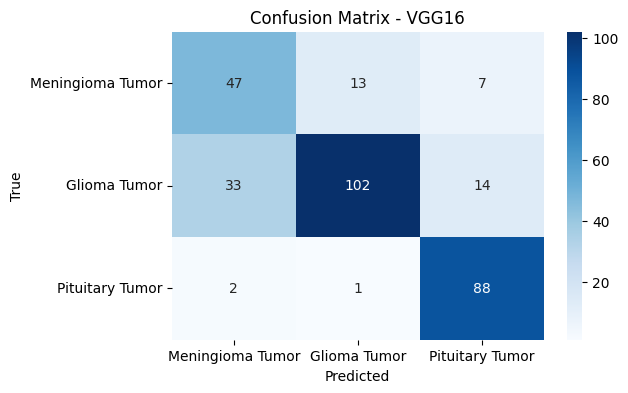

809

In [ ]:
#Predict Labels
y_pred_vgg16 = model_vgg16.predict(x_test_vgg16)
y_pred_classes = np.argmax(y_pred_vgg16, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

#Create classification report
print("Classification Report for VGG16:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

#Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG16')
plt.show()

#Delete references to objects
del x_train_vgg16
del x_valid_vgg16
del x_test_vgg16

#Force a garbage collection
gc.collect()

###**ResNet50 Model**

####**Training + Validating + Testing & Tuning the Model**

In [ ]:
#Set random seed for reproducibility
random.seed(320)
np.random.seed(320)
tf.random.set_seed(320)

#Load ResNet50 pretrained model and freeze the layers
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model.trainable = False

#Add layers on top of the base model by flattening the output and using ReLU activation and softmax output
x = Flatten()(resnet50_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

#Build the final model
model_resnet50 = Model(inputs=resnet50_model.input, outputs=output)

#Set optimizer and loss function
optim = Adam(learning_rate=0.0001)
loss_fn = CategoricalCrossentropy()

#Compile the model
model_resnet50.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

#Print the model summary
model_resnet50.summary()

#Start training the model
print("Training ResNet50 model (224x224 input)")

#Set batch size
batch_size = 24
#Adjust for class weights for imbalance
class_weights = {0: 4.33, 1: 2.15, 2: 3.29}

#Train the model with the training data
model_resnet50.fit(x_train_resnet50, y_train_encoded, epochs=10, validation_data=(x_valid_resnet50, y_valid_encoded),
                   batch_size=batch_size, class_weight=class_weights)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 36,433,283 (138.98 MB)

 Trainable params: 12,845,571 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50 model (224x224 input)
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.3472 - loss: 4.1440 - val_accuracy: 0.5882 - val_loss: 0.9815
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.4975 - loss: 2.9484 - val_accuracy: 0.5817 - val_loss: 0.9117
Epoch 3/10
 50/103 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.6237 - loss: 2.6181

####**Testing the Model**

In [ ]:
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(x_test_resnet50, y_test_encoded)
print("ResNet50 Test Accuracy:", test_acc_resnet50)

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7423 - loss: 0.6538
ResNet50 Test Accuracy: 0.7524430155754089


####**Classification Report & Confusion Matrix**

10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
Classification Report for VGG16:
                  precision    recall  f1-score   support

Meningioma Tumor       0.56      0.75      0.64        67
    Glioma Tumor       0.94      0.62      0.75       149
 Pituitary Tumor       0.75      0.97      0.84        91

        accuracy                           0.75       307
       macro avg       0.75      0.78      0.74       307
    weighted avg       0.80      0.75      0.75       307



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted')

Text(45.72222222222221, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - ResNet50')

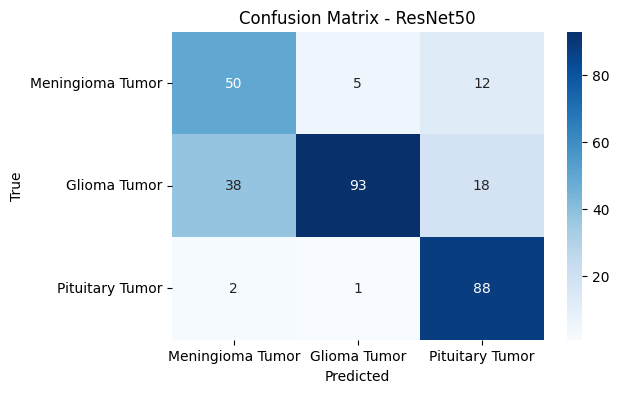

6960

In [ ]:
#Predict Labels
y_pred_resnet50 = model_resnet50.predict(x_test_resnet50)
y_pred_classes = np.argmax(y_pred_resnet50, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

#Create classification report
print("Classification Report for ResNet50:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

#Compute confusion matrix
cm_resnet50 = confusion_matrix(y_true_classes, y_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_resnet50, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# Delete references to objects
del x_train_resnet50
del x_valid_resnet50
del x_test_resnet50

# Force a garbage collection
gc.collect()

### **InceptionV3 Model**

####**Training the Model**

In [ ]:
#Set random seed for reproducibility
random.seed(320)
np.random.seed(320)
tf.random.set_seed(320)

#Load InceptionV3 pretrained model and freeze the layers
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inceptionv3_model.trainable = False

#Add layers on top of the base model by flattening the output and using ReLU activation and softmax output
x = Flatten()(inceptionv3_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

#Build the final model
model_inceptionv3 = Model(inputs=inceptionv3_model.input, outputs=output)

#Set optimizer and loss function
optim = Adam(learning_rate=0.001)
loss_fn = CategoricalCrossentropy()

#Compile the model
model_inceptionv3.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

#Print the model summary
model_inceptionv3.summary()

#Start training the model
print("Training Inceptionv3 model (299x299 input)")

#Set batch size
batch_size = 8
#Adjust for class weights for imbalance
class_weights = {0: 4.33, 1: 2.15, 2: 3.29}

#Train the model with the training data
model_inceptionv3.fit(x_train_inceptionv3, y_train_encoded, epochs=5, validation_data=(x_valid_inceptionv3, y_valid_encoded),
                      batch_size=batch_size, class_weight=class_weights)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 38,580,515 (147.17 MB)

 Trainable params: 16,777,731 (64.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Training Inceptionv3 model (299x299 input)
Epoch 1/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.7246 - loss: 22.2591 - val_accuracy: 0.8497 - val_loss: 0.6835
Epoch 2/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.9139 - loss: 0.7912 - val_accuracy: 0.8660 - val_loss: 0.3460
Epoch 3/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.9529 - loss: 0.3667 - val_accuracy: 0.8758 - val_loss: 0.5022
Epoch 4/5
278/307 ━━━━━━━━━━━━━━━━━━━━ 28s 978ms/step - accuracy: 0.9698 - loss: 0.2751

####**Testing the Model**

In [ ]:
test_loss, test_acc = model_inceptionv3.evaluate(x_test_inceptionv3, y_test_encoded)
print("InceptionV3 Test Accuracy:", test_acc)

####**Classification Report & Confusion Matrix**

In [ ]:
#Predict labels
y_pred_inceptionv3 = model_inceptionv3.predict(x_test_inceptionv3)
y_pred_classes = np.argmax(y_pred_inceptionv3, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

#Create classification report
print("Classification Report for InceptionV3:")
print(classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_inceptionv3, axis=1), target_names=class_names))

#Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Inception V3')
plt.show()
model_inceptionv3.save("model_inceptionv3.h5")

##**DEMO**

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
import gradio as gr
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model

# Load the trained model (InceptionV3) from the previous code
model_inceptionv3 = load_model("model_inceptionv3.h5")


# Define the class labels
class_names = ['Meningioma Tumor', 'Glioma Tumor', 'Pituitary Tumor']

def preprocess_image(img):
    # Resize image to (299, 299) as required by InceptionV3
    img = img.resize((299, 299))

    # Convert image to a numpy array
    img_array = np.array(img)

    # Ensure the image is in the correct format (expand the dimensions to represent a batch)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image for InceptionV3 (e.g., normalization)
    img_array = preprocess_input(img_array)

    return img_array

def execute_inference_pipeline(image_input):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_input)

    # Get model prediction
    prediction = model_inceptionv3.predict(preprocessed_image)

    # Get the predicted class index
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    # Get the predicted class index
    predicted_class_idx = np.argmax(prediction, axis=1)[0]

    # Return the predicted class label
    return class_names[predicted_class_idx]

# Create input and output components for Gradio
inputs = gr.Image(label="Upload Brain MRI Image", type="pil")  # Image input (PIL format)
output = gr.Textbox(label="Prediction")  # Text output (Predicted label)

# Create Gradio interface
gr.Interface(
    fn=execute_inference_pipeline,
    inputs=inputs,
    outputs=output,
    title="Brain Tumor Prediction",
    description="Upload an MRI image to predict the type of brain tumor (Meningioma, Glioma, or Pituitary)."
).launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://518206082699c15dbe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
